<a href="https://colab.research.google.com/github/kithmini-wijesiri/sample_projects/blob/master/Multi_class_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# basic imports
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
datapath = './'

# import autograd wrapped numpy
import autograd.numpy as np

In [ ]:
# look at the content of the file
!cat 3class_data.csv

In [ ]:
!wc 3class_data.csv

##**Multi-class Perceptron**

Here we need to make sure the trained model achieves zero misclassfications.

In [ ]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w,version):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice

        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        if version == 'full':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # normalize components
        if version == 'component':
            component_norm = np.abs(grad_eval) + 10**(-8)
            grad_eval /= component_norm

        if version == 'none':
            grad_eval = grad_eval

        # take gradient descent step
        w = w - alpha*grad_eval

    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(g(w))
    return weight_history,cost_history

In [ ]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [ ]:
lam = 10**-5  # our regularization parameter
def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute maximum across data points
    a = np.max(all_evals,axis = 0)

    # compute cost in compact form
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)

    cost /= float(np.size(y))
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2

    # return average
    return cost

In [ ]:
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

In [ ]:
np.random.seed(5819)
# run gradient descent to minimize cost
g = multiclass_perceptron; w = 0.1*np.random.randn(3,3); max_its = 50; alpha_choice = 10**(-1);
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, version='none')

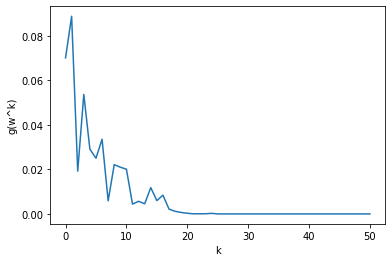

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cost_history);
plt.xlabel("k");
plt.ylabel("g(w^k)");

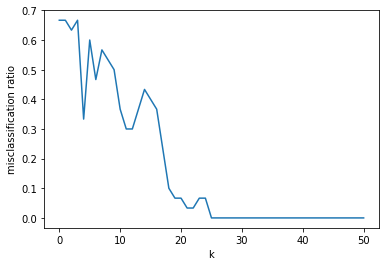

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

#obtain the misclassification history in a list
misc_history = []
for w in weight_history:
    # compare the predictions to the true labels
    predictions = model(x, w)
    misclassified = np.sum(np.argmax(predictions, axis=0) != y.flatten())
    misc_history.append(misclassified)

plt.plot(np.array(misc_history)/y.shape[1]);
plt.xlabel("k");
plt.ylabel("misclassification ratio");

##**Multi-class Softmax**

Here we will use gradient descent for optimization and we need to make sure that the number of misclassifications is below 10.

We can use the implementation of multiclass_perceptron as a basis for our imeplmentation of the multi-class Softmax cost.

In [ ]:
!cat 4class_data.csv

1.255799999999999972e-01,7.718899999999999373e-02,1.716600000000000070e-01,2.960800000000000098e-01,3.605999999999999761e-01,2.131299999999999861e-01,4.596799999999999775e-01,3.329500000000000237e-01,4.688899999999999735e-01,2.131299999999999861e-01,3.905500000000000083e-01,5.241900000000000448e-01,4.389399999999999968e-01,5.864099999999999868e-01,6.094500000000000473e-01,7.039199999999999902e-01,7.361799999999999455e-01,7.522999999999999687e-01,6.854799999999999782e-01,6.117500000000000160e-01,2.477000000000000035e-01,4.988500000000000156e-01,3.790299999999999780e-01,2.776500000000000079e-01,1.601400000000000046e-01,1.463099999999999956e-01,3.099100000000000188e-01,4.297199999999999909e-01,4.873299999999999854e-01,5.380200000000000538e-01,4.366399999999999726e-01,6.624400000000000288e-01,7.730399999999999494e-01,7.891700000000000381e-01,6.509200000000000541e-01,5.587600000000000344e-01,5.817999999999999838e-01,6.486199999999999743e-01,7.453899999999999970e-01,8.606000000000000316e-01


In [ ]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [ ]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**(-5)  # our regularization paramter
# note we are implmenting 7.29 in the text
def multiclass_softmax(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0))

    # compute cost in compact form
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]

    cost = np.sum(a - b)
    cost /= float(np.size(y))

    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2

    # return average
    return cost

In [ ]:
# load in dataset
data = np.loadtxt(datapath + '4class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

In [ ]:
x.shape

(2, 40)

In [ ]:
y.shape

(1, 40)

In [ ]:
np.random.seed(5819)
# run gradient descent to minimize cost
# try different settings so that we can get number of classifications to be below 10
g = multiclass_softmax; w = 0.1*np.random.randn(3,4); alpha_choice = 'diminishing'; max_its = 100;
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, version= 'full')

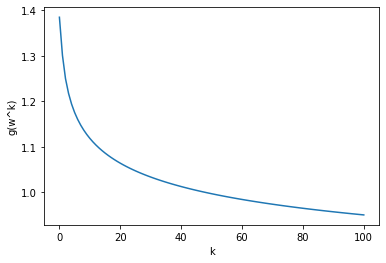

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cost_history);
plt.xlabel("k");
plt.ylabel("g(w^k)");

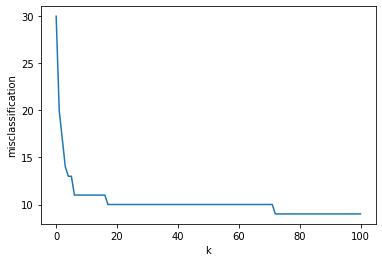

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

misc_history = []
for w in weight_history:
    predictions = model(x, w)
    misclassified = np.sum(np.argmax(predictions, axis=0) != y.flatten())
    misc_history.append(misclassified)

plt.plot(misc_history);
plt.xlabel("k");
plt.ylabel("misclassification");

In [ ]:
y_pred = np.argmax(model(x,weight_history[-1]), axis = 0)
print("number of misclassifications:", np.sum(y_pred != y))

number of misclassifications: 9


In [ ]:
C = int(np.max(y))
L = []
for c in range(C+1):
  ind = np.argwhere(y == c)
  ind = [v[1] for v in ind]
  for d in range(C+1):
    count = 0
    for idx in ind:
      if y_pred[idx] == d:
        count += 1
    L.append(count)
confusion = np.array(L).reshape(C+1,C+1)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[8 2 0 0]
 [1 8 0 1]
 [1 1 6 2]
 [0 1 0 9]]
